<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Deep%20Q-Network%20(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.8 MB/s eta 0:00:00


In [2]:
!pip install gymnasium gymnasium[box2d] stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

import platform
import time
import random
import numpy
import torch
import scipy
import IPython
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import matplotlib
import matplotlib.pyplot
%matplotlib inline

In [4]:
print("Python Version: {}".format(platform.python_version()))
print("Is Cuda Available: {}".format(torch.cuda.is_available()))
print("Torch Version: {}".format(torch.__version__))
print("Cuda Version: {}".format(torch.version.cuda))
print("Scipy Version: {}".format(scipy.__version__))
print("Numpy Version: {}".format(numpy.__version__))
print("Stable Baseline Version: {}".format(stable_baselines3.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Gymnasium Version: {}".format(gymnasium.__version__))

Python Version: 3.10.12
Is Cuda Available: True
Torch Version: 2.3.1+cu121
Cuda Version: 12.1
Scipy Version: 1.13.1
Numpy Version: 1.26.4
Stable Baseline Version: 2.3.2
IPython Version: 7.34.0
Gymnasium Version: 0.29.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [6]:
env = gymnasium.make('LunarLander-v2')
print('State shape: ', env.observation_space)
print('Number of actions: ', env.action_space)
env.close()

State shape:  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Number of actions:  Discrete(4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env.reset()
for step in range(200):
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        env.reset()
env.close()

Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
env = gymnasium.make('LunarLander-v2')
agent = Agent(state_size=8, action_size=4, seed=0)

In [ ]:
def dqn(n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state,info = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=280.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_lunar.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: -152.75
Episode 200	Average Score: -94.37
Episode 300	Average Score: -39.59
Episode 302	Average Score: -39.73

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
env = gymnasium.make('LunarLander-v2',render_mode='rgb_array')

# Wrap the environment to record video
env = RecordVideo(env, video_folder='./video', episode_trigger=lambda e: True)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint_lunar.pth'))

for i in range(3):
    state,info = env.reset()
    for j in range(500):
        action = agent.act(state)
        env.render()
        state, reward, terminated, truncated, info= env.step(action)
        if terminated or truncated:
            break

env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN!
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

## Using Stable Baseline Library for DQN

In [ ]:
# Create Training CarRacing environment
env = gymnasium.make('LunarLander-v2')

# Create Elevation CarRacing environment
env_val = make_vec_env("LunarLander-v2", n_envs=1)

eval_callback = EvalCallback(env_val, best_model_save_path="./logs/", log_path="./logs/", eval_freq=5000, render=False)

# Initialize PPO
model = DQN('MlpPolicy', env, verbose=0)

# Train the model
model.learn(total_timesteps=700000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save("dqn_lunar_lander")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=5000, episode_reward=-712.67 +/- 117.57

Episode length: 407.60 +/- 113.13

New best mean reward!

Eval num_timesteps=10000, episode_reward=-242.22 +/- 40.40

Episode length: 786.20 +/- 268.03

New best mean reward!

Eval num_timesteps=15000, episode_reward=-179.60 +/- 6.39

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-186.50 +/- 15.16

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-157.67 +/- 19.96

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-164.71 +/- 7.55

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-159.37 +/- 20.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-153.16 +/- 10.49

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=45000, episode_reward=-111.91 +/- 20.48

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50000, episode_reward=-144.38 +/- 16.70

Eval num_timesteps=55000, episode_reward=-107.55 +/- 26.25

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=60000, episode_reward=-88.58 +/- 24.52

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=65000, episode_reward=-100.89 +/- 15.38

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=70000, episode_reward=-116.67 +/- 10.98

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=75000, episode_reward=-101.10 +/- 23.89

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=-129.81 +/- 27.46

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=85000, episode_reward=-128.99 +/- 20.36

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=90000, episode_reward=-122.36 +/- 12.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=95000, episode_reward=-127.47 +/- 18.66

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=-120.37 +/- 12.99

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=105000, episode_reward=-108.72 +/- 22.48

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=110000, episode_reward=-130.57 +/- 23.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=115000, episode_reward=-107.03 +/- 31.98

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=-59.04 +/- 106.86

Episode length: 959.40 +/- 81.20

New best mean reward!

Eval num_timesteps=125000, episode_reward=-107.34 +/- 15.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=130000, episode_reward=-126.24 +/- 31.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=135000, episode_reward=-98.95 +/- 33.65

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=140000, episode_reward=-101.36 +/- 8.88

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=145000, episode_reward=-90.87 +/- 31.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-89.00 +/- 42.27

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=155000, episode_reward=-98.25 +/- 24.15

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=160000, episode_reward=-106.76 +/- 47.45

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=165000, episode_reward=-113.67 +/- 27.14

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=-85.47 +/- 32.38

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=175000, episode_reward=-39.73 +/- 51.40

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=180000, episode_reward=-101.92 +/- 69.26

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=185000, episode_reward=-69.74 +/- 31.39

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=190000, episode_reward=-61.21 +/- 85.07

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=195000, episode_reward=-39.73 +/- 54.61

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=200000, episode_reward=-49.82 +/- 71.96

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=205000, episode_reward=-32.83 +/- 24.85

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=210000, episode_reward=-24.81 +/- 54.96

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=215000, episode_reward=5.07 +/- 17.34

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=220000, episode_reward=19.16 +/- 120.87

Episode length: 937.60 +/- 124.80

New best mean reward!

Eval num_timesteps=225000, episode_reward=-23.76 +/- 56.74

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=230000, episode_reward=-30.20 +/- 35.31

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=235000, episode_reward=35.21 +/- 81.27

Episode length: 776.20 +/- 311.05

New best mean reward!

Eval num_timesteps=240000, episode_reward=-67.55 +/- 34.17

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=245000, episode_reward=108.35 +/- 90.32

Episode length: 886.60 +/- 169.09

New best mean reward!

Eval num_timesteps=250000, episode_reward=-7.42 +/- 44.52

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=255000, episode_reward=44.49 +/- 110.06

Episode length: 561.20 +/- 363.52

Eval num_timesteps=260000, episode_reward=92.00 +/- 104.61

Episode length: 892.80 +/- 142.60

Eval num_timesteps=265000, episode_reward=150.68 +/- 90.01

Episode length: 714.40 +/- 184.07

New best mean reward!

Eval num_timesteps=270000, episode_reward=67.56 +/- 123.31

Episode length: 516.60 +/- 172.85

Eval num_timesteps=275000, episode_reward=79.11 +/- 87.67

Episode length: 483.80 +/- 226.21

Eval num_timesteps=280000, episode_reward=167.83 +/- 29.15

Episode length: 641.20 +/- 97.59

New best mean reward!

Eval num_timesteps=285000, episode_reward=36.32 +/- 75.78

Episode length: 908.20 +/- 183.60

Eval num_timesteps=290000, episode_reward=103.06 +/- 129.30

Episode length: 475.40 +/- 170.07

Eval num_timesteps=295000, episode_reward=106.11 +/- 109.29

Episode length: 439.80 +/- 189.27

Eval num_timesteps=300000, episode_reward=125.69 +/- 129.08

Episode length: 600.00 +/- 176.42

Eval num_timesteps=305000, episode_reward=140.78 +/- 93.89

Episode length: 509.60 +/- 292.06

Eval num_timesteps=310000, episode_reward=132.19 +/- 110.98

Episode length: 623.40 +/- 207.42

Eval num_timesteps=315000, episode_reward=55.05 +/- 146.26

Episode length: 354.20 +/- 104.65

Eval num_timesteps=320000, episode_reward=148.83 +/- 120.20

Episode length: 542.00 +/- 281.83

Eval num_timesteps=325000, episode_reward=210.12 +/- 46.36

Episode length: 543.60 +/- 104.78

New best mean reward!

Eval num_timesteps=330000, episode_reward=15.02 +/- 54.82

Episode length: 594.40 +/- 337.65

Eval num_timesteps=335000, episode_reward=108.82 +/- 90.57

Episode length: 445.60 +/- 173.00

Eval num_timesteps=340000, episode_reward=35.35 +/- 66.83

Episode length: 581.00 +/- 350.86

Eval num_timesteps=345000, episode_reward=-3.90 +/- 124.40

Episode length: 339.60 +/- 140.21

Eval num_timesteps=350000, episode_reward=86.88 +/- 120.06

Episode length: 442.20 +/- 237.03

Eval num_timesteps=355000, episode_reward=70.32 +/- 108.97

Episode length: 509.80 +/- 299.65

Eval num_timesteps=360000, episode_reward=5.88 +/- 114.52

Episode length: 521.80 +/- 293.36

Eval num_timesteps=365000, episode_reward=-1.91 +/- 97.20

Episode length: 372.40 +/- 223.15

Eval num_timesteps=370000, episode_reward=34.76 +/- 127.10

Episode length: 567.60 +/- 267.64

Eval num_timesteps=375000, episode_reward=21.72 +/- 107.76

Episode length: 607.20 +/- 284.26

Eval num_timesteps=380000, episode_reward=90.96 +/- 92.07

Episode length: 679.60 +/- 136.40

Eval num_timesteps=385000, episode_reward=23.45 +/- 123.08

Episode length: 590.20 +/- 244.52

Eval num_timesteps=390000, episode_reward=-67.67 +/- 35.01

Episode length: 403.80 +/- 311.28

Eval num_timesteps=395000, episode_reward=-43.52 +/- 142.58

Episode length: 333.20 +/- 38.36

Eval num_timesteps=400000, episode_reward=67.14 +/- 127.58

Episode length: 441.40 +/- 223.13

Eval num_timesteps=405000, episode_reward=-111.55 +/- 66.86

Episode length: 307.00 +/- 248.18

Eval num_timesteps=410000, episode_reward=68.85 +/- 86.38

Episode length: 615.80 +/- 187.01

Eval num_timesteps=415000, episode_reward=16.87 +/- 162.23

Episode length: 365.40 +/- 103.80

Eval num_timesteps=420000, episode_reward=-65.14 +/- 119.38

Episode length: 321.60 +/- 130.73

Eval num_timesteps=425000, episode_reward=-134.57 +/- 130.03

Episode length: 651.80 +/- 301.35

Eval num_timesteps=430000, episode_reward=-14.82 +/- 102.93

Episode length: 680.20 +/- 265.65

Eval num_timesteps=435000, episode_reward=-81.54 +/- 47.06

Episode length: 412.00 +/- 299.15

Eval num_timesteps=440000, episode_reward=47.68 +/- 131.64

Episode length: 519.40 +/- 261.03

Eval num_timesteps=445000, episode_reward=-40.53 +/- 148.38

Episode length: 340.80 +/- 161.97

Eval num_timesteps=450000, episode_reward=-11.52 +/- 127.98

Episode length: 550.80 +/- 277.87

Eval num_timesteps=455000, episode_reward=7.23 +/- 141.90

Episode length: 706.00 +/- 360.22

Eval num_timesteps=460000, episode_reward=72.76 +/- 139.10

Episode length: 485.60 +/- 180.08

Eval num_timesteps=465000, episode_reward=-41.75 +/- 47.25

Episode length: 722.00 +/- 346.65

Eval num_timesteps=470000, episode_reward=58.72 +/- 153.75

Episode length: 630.80 +/- 268.55

Eval num_timesteps=475000, episode_reward=-26.87 +/- 156.02

Episode length: 427.40 +/- 287.17

Eval num_timesteps=480000, episode_reward=88.72 +/- 132.34

Episode length: 678.20 +/- 280.79

Eval num_timesteps=485000, episode_reward=-41.83 +/- 131.51

Episode length: 581.60 +/- 280.65

Eval num_timesteps=490000, episode_reward=-98.41 +/- 47.93

Episode length: 774.80 +/- 257.00

Eval num_timesteps=495000, episode_reward=70.44 +/- 149.37

Episode length: 761.20 +/- 304.33

Eval num_timesteps=500000, episode_reward=-47.72 +/- 130.39

Episode length: 642.60 +/- 317.06

Eval num_timesteps=505000, episode_reward=-12.19 +/- 89.05

Episode length: 515.80 +/- 326.66

Eval num_timesteps=510000, episode_reward=125.00 +/- 98.31

Episode length: 740.40 +/- 207.26

Eval num_timesteps=515000, episode_reward=49.26 +/- 121.14

Episode length: 694.20 +/- 375.40

Eval num_timesteps=520000, episode_reward=-33.14 +/- 144.89

Episode length: 763.00 +/- 205.04

Eval num_timesteps=525000, episode_reward=15.58 +/- 126.21

Episode length: 697.60 +/- 308.41

Eval num_timesteps=530000, episode_reward=36.57 +/- 117.87

Episode length: 797.60 +/- 203.99

Eval num_timesteps=535000, episode_reward=29.74 +/- 124.29

Episode length: 922.00 +/- 130.68

Eval num_timesteps=540000, episode_reward=67.36 +/- 81.27

Episode length: 789.80 +/- 302.65

Eval num_timesteps=545000, episode_reward=-54.67 +/- 110.09

Episode length: 808.40 +/- 235.00

Eval num_timesteps=550000, episode_reward=55.73 +/- 76.55

Episode length: 781.40 +/- 287.63

Eval num_timesteps=555000, episode_reward=-41.14 +/- 38.52

Episode length: 736.40 +/- 332.99

Eval num_timesteps=560000, episode_reward=77.26 +/- 115.53

Episode length: 798.40 +/- 267.57

Eval num_timesteps=565000, episode_reward=-14.49 +/- 76.89

Episode length: 883.60 +/- 232.80

Eval num_timesteps=570000, episode_reward=59.14 +/- 83.14

Episode length: 914.20 +/- 108.16

Eval num_timesteps=575000, episode_reward=15.57 +/- 52.70

Episode length: 835.20 +/- 302.38

Eval num_timesteps=580000, episode_reward=-31.57 +/- 33.91

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=585000, episode_reward=-21.45 +/- 17.32

Episode length: 843.00 +/- 314.00

Eval num_timesteps=590000, episode_reward=82.42 +/- 160.80

Episode length: 585.40 +/- 110.98

Eval num_timesteps=595000, episode_reward=124.36 +/- 103.17

Episode length: 806.40 +/- 252.01

Eval num_timesteps=600000, episode_reward=-1.80 +/- 14.60

Episode length: 844.40 +/- 311.20

Eval num_timesteps=605000, episode_reward=5.30 +/- 57.21

Episode length: 999.00 +/- 2.00

Eval num_timesteps=610000, episode_reward=-24.84 +/- 20.16

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=615000, episode_reward=-19.27 +/- 30.05

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=620000, episode_reward=-4.86 +/- 36.87

Episode length: 839.80 +/- 320.40

Eval num_timesteps=625000, episode_reward=-74.01 +/- 55.04

Episode length: 964.60 +/- 70.80

Eval num_timesteps=630000, episode_reward=87.70 +/- 128.14

Episode length: 769.20 +/- 288.35

Eval num_timesteps=635000, episode_reward=43.12 +/- 84.46

Episode length: 935.00 +/- 130.00

Eval num_timesteps=640000, episode_reward=72.55 +/- 85.92

Episode length: 907.20 +/- 135.62

Eval num_timesteps=645000, episode_reward=141.39 +/- 55.57

Episode length: 879.60 +/- 103.67

Eval num_timesteps=650000, episode_reward=176.09 +/- 89.66

Episode length: 624.00 +/- 201.92

Eval num_timesteps=655000, episode_reward=134.83 +/- 78.67

Episode length: 843.00 +/- 140.10

Eval num_timesteps=660000, episode_reward=135.31 +/- 87.84

Episode length: 774.20 +/- 132.65

Eval num_timesteps=665000, episode_reward=158.20 +/- 82.29

Episode length: 696.20 +/- 201.57

Eval num_timesteps=670000, episode_reward=166.54 +/- 17.60

Episode length: 727.60 +/- 97.87

Eval num_timesteps=675000, episode_reward=176.87 +/- 44.83

Episode length: 686.80 +/- 175.23

Eval num_timesteps=680000, episode_reward=173.60 +/- 46.18

Episode length: 748.20 +/- 175.46

Eval num_timesteps=685000, episode_reward=203.45 +/- 8.43

Episode length: 566.20 +/- 66.40

Eval num_timesteps=690000, episode_reward=156.81 +/- 32.57

Episode length: 797.80 +/- 128.36

Eval num_timesteps=695000, episode_reward=180.93 +/- 15.00

Episode length: 711.80 +/- 57.70

Eval num_timesteps=700000, episode_reward=70.12 +/- 109.15

Episode length: 878.00 +/- 189.00

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 57.04 +/- 67.39


In [ ]:
# Create Elevation CarRacing environment
env = make_vec_env("LunarLander-v2", n_envs=1, seed=0)

# Load the best model
best_model_path = "./logs/best_model.zip"
best_model = DQN.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=15)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/", video_length=5000, record_video_trigger=lambda x: x == 0, name_prefix="best_model_dqn_lunar_lander")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 81.14 +/- 90.74
Moviepy - Building video /content/videos/best_model_dqn_lunar_lander-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_dqn_lunar_lander-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_dqn_lunar_lander-step-0-to-step-5000.mp4


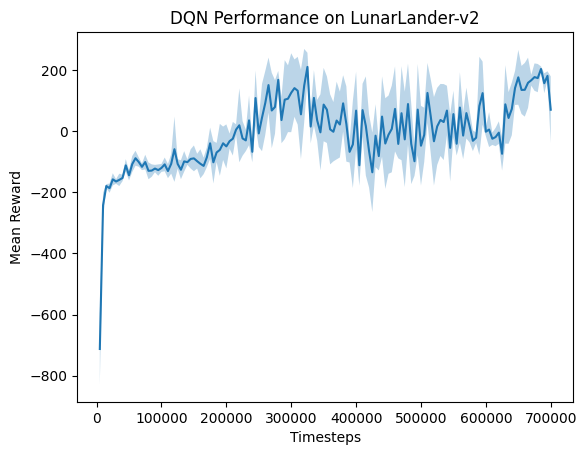

In [ ]:
# Load the evaluations.npz file
data = numpy.load('./logs/evaluations.npz')

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.3)
matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('DQN Performance on LunarLander-v2')
matplotlib.pyplot.show()